<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [55]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')

data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [56]:
print('Unique words - ', data['Word'].nunique())
print('Unique tags  - ', data['Tag'].nunique())

Unique words -  35178
Unique tags  -  17


In [57]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

num_words = len(words)

In [58]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [59]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [60]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        
        agg_func = lambda s: [(w, p, t) for w, p , t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [61]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [62]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [63]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i+1 for i, t in enumerate(tags)}

In [64]:
word2idx

{'scanned': 1,
 'Nozari': 2,
 'Hodan': 3,
 'trash': 4,
 'anti-poppy': 5,
 'mad-cow': 6,
 'Dizzy': 7,
 'boats': 8,
 'undertaken': 9,
 'Akre-Bijeel': 10,
 'Danielle': 11,
 'Hadson': 12,
 'year-round': 13,
 'Zoba': 14,
 'All-Star': 15,
 'omen': 16,
 'presence': 17,
 'EEBC': 18,
 'memo': 19,
 'occupied': 20,
 'disadvantages': 21,
 'Korangal': 22,
 'Iyad': 23,
 'municipal': 24,
 'tolerant': 25,
 'order': 26,
 'Conviasa': 27,
 'shouting': 28,
 'hotels': 29,
 'thrifty': 30,
 'Idema': 31,
 'Specific': 32,
 'Referenda': 33,
 'OIC': 34,
 'Triangle': 35,
 'retaliated': 36,
 'fund': 37,
 'contracts': 38,
 'River': 39,
 'drawback': 40,
 '1853': 41,
 'Nest': 42,
 'online': 43,
 'member-states': 44,
 'takeoff': 45,
 'F.': 46,
 'redistricting': 47,
 'State': 48,
 'Srinigar': 49,
 '787s': 50,
 'Suef': 51,
 'Zamboanga': 52,
 'Spinetta': 53,
 'veto-wielding': 54,
 'insurgent': 55,
 '1.5': 56,
 'aspirations': 57,
 'Teikoku': 58,
 'Tegucigalpa': 59,
 'Momir': 60,
 'Byers': 61,
 '786': 62,
 'spilled': 63,
 

### Task 5: Padding Input Sentences and Creating Train/Test Splits

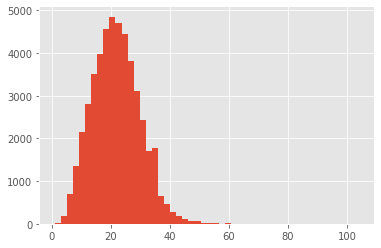

In [65]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [66]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)


y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])

y=[to_categorical(i-1, num_classes=num_tags) for i in y]

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [68]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [69]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Task 7: Train the Model

In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=1, 
    verbose=0, 
    mode='max', 
    restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]


history=model.fit(
    X_train,
    np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=True,
    callbacks=callbacks
)

Train on 34530 samples, validate on 8633 samples
Epoch 1/3
31008/34530 [=========================>....] - ETA: 21s - loss: 0.2039 - accuracy: 0.9545

### Task 8: Evaluate Named Entity Recognition Model

In [ ]:
model.evaluate(X_test, np.array(y_test))

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array(X_test[i]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test(), axis=-1))[i]

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-"*30)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{:5}\t {}\n".format(words[w-1], tags[true], tags[pred]))
